In [1]:
from osgeo import gdal,gdal_array
from math import sqrt
import sys
import pandas as pd
import numpy as np
from qgis.PyQt.QtCore import QVariant
from qgis import processing
from qgis.core import QgsVectorLayer,QgsField,QgsFeature,QgsVectorFileWriter,QgsRasterLayer,QgsApplication,edit
from getInput import getWebRasterLayer,getBboxWmsFormat

#for developing
QgsApplication.setPrefixPath(r'C:\OSGeo4W\apps\qgis', True)
qgs = QgsApplication([], False)
qgs.initQgis()
sys.path.append(r'C:\OSGeo4W\apps\qgis\python\plugins')
import processing
from processing.core.Processing import Processing
Processing.initialize()
#import processing
from qgis.analysis import QgsNativeAlgorithms
#from processing.core.Processing import Processing

import geopandas as gpd
import rasterio
from rasterio.plot import show

In [2]:
#example weblayers
chm = 'https://rajapinnat.metsaan.fi/geoserver/Avoinmetsatieto/CHM_newest/ows?'

<>:2: DeprecationWarning: invalid escape sequence \R
<>:2: DeprecationWarning: invalid escape sequence \R
C:\Users\mkesala\AppData\Local\Temp\ipykernel_20144\320352058.py:2: DeprecationWarning: invalid escape sequence \R
  data_example = "data_example\ReTreeT.gpkg"


<AxesSubplot:>

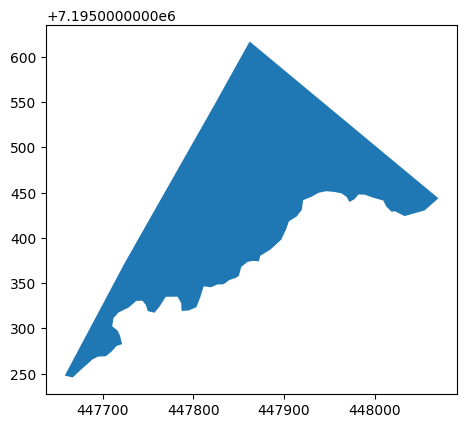

In [3]:
#example cutting area
data_example = "data_example\ReTreeT.gpkg"
layer = "cuttingarea"
data_qgis = QgsVectorLayer(data_example+"|layername="+layer,"cutarea","ogr")
data_df = gpd.read_file(data_example,layer = layer)

data_df

data_df.plot()

In [4]:
def feature2Layer(feat,buffer):
    """
    This creates vectorlayer from feature. You can buffer feature at specific distance
    """
    vl = QgsVectorLayer("Polygon", "temporary_points", "memory")
    pr = vl.dataProvider()

    # add fields
    vl.startEditing()
    pr.addAttributes(feat.fields())
    vl.updateFields() # tell the vector layer to fetch changes from the provider

    fet = QgsFeature()
    fet.setGeometry(feat.geometry().buffer(buffer,5))
    #fet.setGeometry(feat.geometry())
    fet.setAttributes(feat.attributes())
    pr.addFeatures([fet])

    vl.updateExtents()
    vl.commitChanges()

    return vl


In [5]:
features= data_qgis.getFeatures()

#we test first feature data
print ( [field.name() for field in data_qgis.fields()])
print ( [(feature.geometry().area(),feature['fid']) for current,feature in enumerate(data_qgis.getFeatures()) if current == 0])

featlayer = [feature2Layer(feature,100) for current, feature in enumerate(data_qgis.getFeatures()) if current == 0]
featlayer[0].setCrs(data_qgis.crs())
#we test saved vector layer data 
print ( [field.name() for field in featlayer[0].fields()])
print ( [(f.geometry().area(),f['fid']) for f in featlayer[0].getFeatures()])

['fid', 'STANDNUMBER']
[(45575.672119140625, 14)]
['fid', 'STANDNUMBER']
[(196954.72290039062, 14)]


In [6]:
def copyRaster2(inp,outp):
    """
    This is simple raster copy
    """
    os.popen('copy '+inp+' '+outp)

In [7]:
def focalMaximaCHM(input_raster,distance):
    """
    This calculates focal maximum value by specific search distance
    """
    
    rastOut = input_raster[0:-4]+"hh.tif"
    chm = gdal.Open(input_raster)
    
    chmB = chm.GetRasterBand(1)
    chmA = chmB.ReadAsArray()
    chmA = (chmA-126)*0.232 #vaihe 1

    focal = calcFocal(chmA,distance) #vaihe 2
    huip = focal - chmA
    huip = np.where(focal-chmA==0,chmA,np.NaN)
    huip = np.where(huip>=5,huip*10,np.NaN) #vaihe3
    gdal_array.SaveArray(huip.astype("float32"),rastOut,"GTiff",chm)

    return rastOut

In [8]:
def calcFocal(in_array,distance):
    """
    This loops raster array and looks all cell values of each cell which are within distance values from cell
    """

    dat =pd.DataFrame(in_array)
    vert = dat
    ijlist = []
    for i in range(0-distance,distance):
        for j in range(0-distance,distance):
            e = sqrt(pow(i,2)+pow(j,2))
            if e <=distance:
                ijlist.append((i,j))
    
    #print (ijlist)

    for i in ijlist:
        df = dat.shift(i[0],axis=0)
        df = df.shift(i[1],axis=1)
        vert = pd.concat([vert,df]).max(level=0)
    t = []
    t.append(vert)
    t = np.array(t)

    return t

C:\git\smk_tools\processing\getInput.py:150: ResourceWarning: unclosed file <_io.BufferedRandom name=5>
  tempd = tempd.name+'.tif'
C:\git\smk_tools\processing\getInput.py:170: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\Users\\mkesala\\AppData\\Local\\Temp\\tmphbtzm0bd.tif'>
  open(tempd,'wb').write(respo.content)


1.0 1.0
1.0 1.0


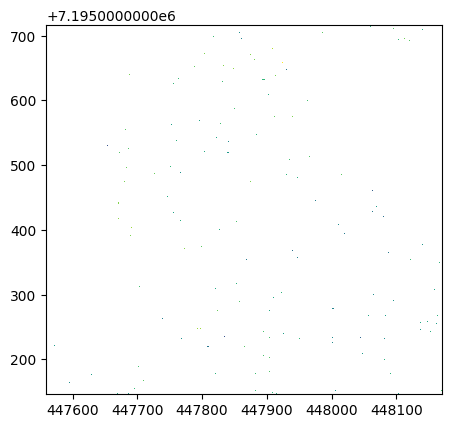

<AxesSubplot:>

In [9]:
#we test focal maxima algorithm
chm_raster = getWebRasterLayer(featlayer[0],chm,"")
chm_qgis = QgsRasterLayer(chm_raster[0], "Your Raster Layer")
print (chm_qgis.rasterUnitsPerPixelX(),chm_qgis.rasterUnitsPerPixelY())
focalMax = focalMaximaCHM(chm_raster[0],4)
focal_qgis = QgsRasterLayer(focalMax, "Your Raster Layer")
print (focal_qgis.rasterUnitsPerPixelX(),focal_qgis.rasterUnitsPerPixelY())
test_raster = rasterio.open(focalMax)
show(test_raster)

In [10]:
def delNulls(input_vector):
    """
    This deletes null-values of treemap  
    """
    input_vector = QgsVectorLayer(input_vector, "puukartta", "ogr")
    

    feats = input_vector.getFeatures()
    dfeat=[]
    
    for feat in feats:
        if feat['CHM'] < 0:
            dfeat.append(feat.id())

    input_vector.dataProvider().deleteFeatures(dfeat)

In [11]:
def createTreeMap(input_chm,distance):
    """
    This creates tree map as point layer from chm raster. Algorithm is based on local maxima at specific search distance
    """
    #tempd = tempfile.TemporaryFile()
    #tempd = tempd.name+'.shp'
    focalMax = focalMaximaCHM(input_chm,distance)
    tempd = processing.run("gdal:polygonize", {'INPUT':focalMax,'BAND':1,'FIELD':'CHM','EIGHT_CONNECTEDNESS':False,'EXTRA':'','OUTPUT':'TEMPORARY_OUTPUT'})
    
    delNulls(tempd['OUTPUT'])
    tempd = processing.run("native:centroids", {'INPUT':tempd['OUTPUT'],'ALL_PARTS':False,'OUTPUT':'TEMPORARY_OUTPUT'})
    processing.run("native:createspatialindex", {'INPUT':tempd['OUTPUT']})

    return tempd['OUTPUT']

In [12]:
#We test chm2treemap conversion
chm_raster = getWebRasterLayer(featlayer[0],chm,"")
treemap = createTreeMap(chm_raster[0],3)

print (treemap.featureCount())

C:\git\smk_tools\processing\getInput.py:170: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\Users\\mkesala\\AppData\\Local\\Temp\\tmpb5ow0y51.tif'>
  open(tempd,'wb').write(respo.content)


5913


In [13]:
def addFieldValue(in_feat:QgsVectorLayer,fieldname:str,fieldvalue:float):
    """
    This adds field with given value to the vector layer
    """
    fix = processing.run("native:fixgeometries", {'INPUT':in_feat,'OUTPUT':'TEMPORARY_OUTPUT'})
    fix['OUTPUT'].dataProvider().addAttributes([QgsField(fieldname,QVariant.Double)])
    fix['OUTPUT'].updateFields()
    with edit(fix['OUTPUT']):
        for feat in fix['OUTPUT'].getFeatures():
            feat['leimikko']=fieldvalue

            fix['OUTPUT'].updateFeature(feat)
    
    return fix['OUTPUT']

In [15]:
print ([f.name() for f in featlayer[0].fields()])
test = addFieldValue(featlayer[0],"leimikko",1)
print ([f.name() for f in test.fields()])
print (max([f['leimikko'] for f in test.getFeatures()]))

['fid', 'STANDNUMBER']
['fid', 'STANDNUMBER', 'leimikko']
1.0


In [16]:
def joinIntersection(inlayer,joinlayer,joinfields):
    """
    This join by spatial intersection two layers
    """
    joined = processing.run("native:joinattributesbylocation", {'INPUT':inlayer,'JOIN':joinlayer,'PREDICATE':[0],'JOIN_FIELDS':joinfields,'METHOD':0,'DISCARD_NONMATCHING':False,'PREFIX':'','OUTPUT':'TEMPORARY_OUTPUT'})

    return joined['OUTPUT']
